In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
loss = np.load("trained_models/loss_lsst_u.npy")
val = np.load("trained_models/valloss_lsst_u.npy")
lr = np.load("trained_models/lr_lsst_u.npy")

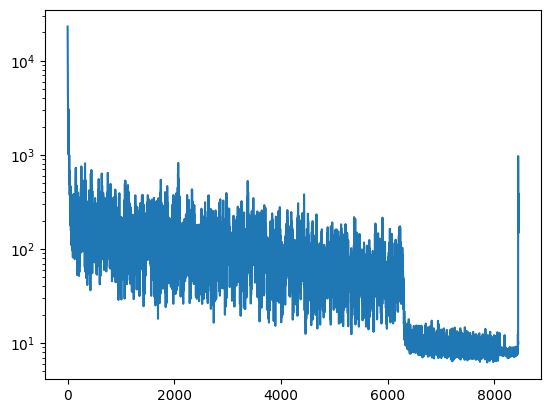

In [3]:
plt.plot(loss)
plt.yscale("log")

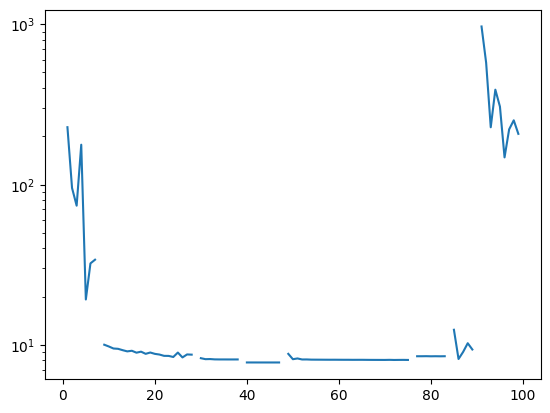

In [4]:
plt.plot(val)
plt.yscale("log")

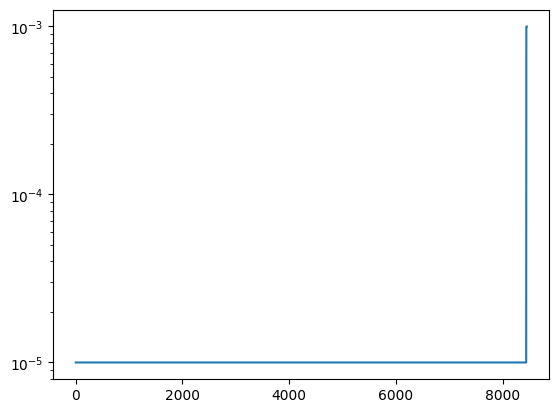

In [5]:
plt.plot(lr)
plt.yscale("log")